In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras import Model, Sequential
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os


In [2]:
DATA_FILE = "x.npy"

batch_size = 32
codings_size = 384

## Load Data
Load data and split it into batches. Split into batches because the model(s) has/have a custom training loop and is trained one batch at a time so splitting the data now makes it a little easier later.

In [3]:
x = np.load(DATA_FILE)
img_shape = x.shape[1:]
batches = np.split(x[:len(x)//batch_size * batch_size], len(x)//batch_size)
del x

## Define the Models

In [4]:
input_tensor = Input(shape=img_shape)

c1 = Conv2D(6, 5, strides=2, padding="same", activation='selu')
c2 = Conv2D(12, 3, strides=2, padding="same", activation='selu')
c3 = Conv2D(24, 3, strides=2, padding="same", activation='selu')
c4 = Conv2D(48, 3, strides=2, padding="same", activation='selu')
c5 = Conv2D(96, 3, strides=2, padding="same", activation='selu')
c6 = Conv2D(192, 3, strides=2, padding="same", activation='selu')
c7 = Conv2D(codings_size, 3, strides=2, padding="same", activation='selu')

bn1 = BatchNormalization()
bn2 = BatchNormalization()
bn3 = BatchNormalization()
bn4 = BatchNormalization()
bn5 = BatchNormalization()
bn6 = BatchNormalization()
bn7 = BatchNormalization()

up = UpSampling2D()

ct1 = Conv2DTranspose(192, 3, strides=2, padding="same", activation='selu')
ct2 = Conv2DTranspose(96, 3, strides=2, padding="same", activation='selu')
ct3 = Conv2DTranspose(48, 3, strides=2, padding="same", activation='selu')
ct4 = Conv2DTranspose(24, 3, strides=2, padding="same", activation='selu')
ct5 = Conv2DTranspose(12, 3, strides=2, padding="same", activation='selu')
ct6 = Conv2DTranspose(6, 3, strides=2, padding="same", activation='selu')
ct7 = Conv2D(3, 5, strides=1, padding="same", activation='sigmoid')

In [5]:
# training_models = [
#     Sequential([input_tensor, c1, bn1, ct6]),
#     Sequential([input_tensor, c1, bn1, c2, bn2, ct5]),
#     Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, ct4]),
#     Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, ct3]),
#     Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, ct2]),
#     Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, ct1]),
# ]

training_models = [
    Sequential([input_tensor, c1, bn1, up, ct7]),
    Sequential([input_tensor, c1, bn1, c2, bn2, ct6]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, ct5]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, ct4]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, ct3]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, ct2]),
    Sequential([input_tensor, c1, bn1, c2, bn2, c3, bn3, c4, bn4, c5, bn5, c6, bn6, c7, bn7, ct1]),
]

targets = []

z = input_tensor
targets.append(z)
z = c1(z)
targets.append(z)
z = bn1(z)
z = c2(z)
targets.append(z)
z = bn2(z)
z = c3(z)
targets.append(z)
z = bn3(z)
z = c4(z)
targets.append(z)
z = bn4(z)
z = c5(z)
targets.append(z)
z = bn5(z)
z = c6(z)
targets.append(z)
z = bn6(z)
z = c7(z)
z = bn7(z)

for layer in [ct1, bn6, ct2, bn5, ct3, bn4, ct4, bn3, ct5, bn2, ct6, bn1, up, ct7]:
    z = layer(z)

output_tensor = z

for i, model in enumerate(training_models):
    j = -3 if i > 0 else -4
    for layer in model.layers[:j]:
        layer.trainable = False
    model.compile(optimizer="adam", loss="MSE", metrics=["mean_absolute_error"])
    model.summary()

target_model = Model(inputs=[input_tensor], outputs=targets)
inference_model = Model(inputs=[input_tensor], outputs=[z])

stacked_model = keras.models.clone_model(inference_model)
stacked_model.compile(optimizer="adam", loss="MSE", metrics=["mean_absolute_error"])
stacked_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 3)       453       
Total params: 933
Trainable params: 921
Non-trainable params: 12
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 6)         456       
___________________________________

In [6]:
def train_step(batch):
    targets = target_model.predict(batch)

    for i, model in enumerate(training_models):
        model.train_on_batch(batch, targets[i])
    
    stacked_model.train_on_batch(batch, batch)

# inference_model = keras.models.load_model("inference.h5")
# stacked_model = keras.models.load_model("stacked.h5")

epochs = 10
for i in range(epochs):
    print("\nEpoch %d/%d" % (i, epochs))
    for batch in tqdm(batches):
        train_step(batch)

  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 0/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 1/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 2/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 3/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 4/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 5/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 6/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 7/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 8/10
  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 9/10
100%|██████████| 413/413 [02:01<00:00,  3.39it/s]


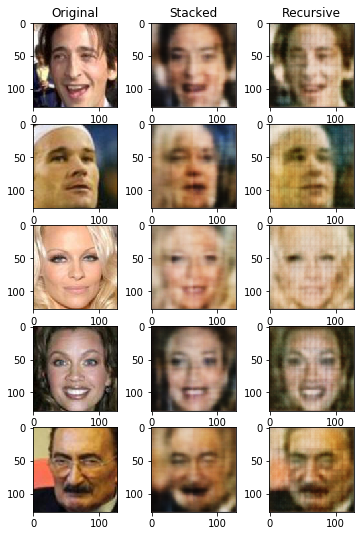

In [9]:
batches = np.array(batches)
B, N, _, _, _ = batches.shape
num_images = 5
batches_ind = np.random.randint(0, B, num_images)
imgs = np.random.randint(0, N, num_images)
display_images = batches[batches_ind, imgs, :, :, :]

reconstructions = inference_model.predict(display_images)
basic_reconstructions = stacked_model.predict(display_images)

fig, axs = plt.subplots(5, 3)

titles = ["Original", "Stacked", "Recursive"]

for r, row in enumerate(axs):
    imgs = [display_images[r], basic_reconstructions[r], reconstructions[r]]
    for c, ax in enumerate(row):
        img = imgs[c].astype(float)
        ax.imshow(img)
        if r == 0:
            ax.set_title(titles[c])

fig.set_size_inches(6, 9)
fig.savefig("faces.png")
fig.show()

In [9]:
inference_model.save("../models/up_SB_R_7_384.h5")
stacked_model.save("../models/up_SB_S_7_384.h5")